In [42]:
### import libraries

import glob
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy.signal import iirnotch, filtfilt
import random
import pywt 
from sklearn.model_selection import StratifiedKFold, train_test_split
import time
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from tabulate import tabulate
from scipy.signal import spectrogram
from sklearn.svm import SVC

In [3]:
### Define global variables
sampling_rate = 173.61  # sampling freq of Adjek

# Folder paths for each set
folders = {
    'A': './data/Z',  # Z000.txt - Z100.txt
    'B': './data/O',  # O000.txt - O100.txt
    'C': './data/N',  # N000.txt - N100.txt
    'D': './data/F',  # F000.txt - F100.txt
    'E': './data/S'   # S000.txt - S100.txt
}

In [4]:
### Load and preprocess the data

# Initialize dictionaries to store the raw and filtered data
raw_data_all_sets = {key: [] for key in folders.keys()}
filtered_data_all_sets = {key: [] for key in folders.keys()}

# Function to apply a notch filter to remove 50Hz noise
def notch_filter(data, freq=50.0, fs=256.0, Q=30.0):
    """
    Apply a notch filter to remove the 50Hz line noise.
    Parameters:
        data: 1D array of EEG data
        freq: Frequency to remove (60 Hz)
        fs: Sampling rate of the data
        Q: Quality factor (controls bandwidth of the notch)
    """
    w0 = freq / (fs / 2)  # Normalize frequency
    b, a = iirnotch(w0, Q)  # Create notch filter
    filtered_data = filtfilt(b, a, data)  # Apply filter
    return filtered_data

# Define categories for scalp and intracranial data
scalp_sets = ["A", "B"]
intracranial_sets = ["C", "D"]
intracranial_siezure_sets = ["E"]
# total_sets = scalp_sets + intracranial_sets

# Step 1: Compute global mean and standard deviation for each category
global_stats = {}

# Helper function to calculate global stats for a given list of sets
def calculate_global_stats(sets):
    all_data = []
    for set_name in sets:
        folder_path = folders[set_name]
        txt_files = glob.glob(os.path.join(folder_path, "*.txt"))
        
        for file in txt_files:
            data = pd.read_csv(file, delimiter="\t", header=None)
            eeg_data = data[0].values
            all_data.extend(eeg_data)  # Add data to list
    
    # Calculate mean and std for the given sets
    global_mean = np.mean(all_data)
    global_std = np.std(all_data)
    return global_mean, global_std

# Calculate and store global statistics for scalp and intracranial categories
global_stats['scalp'] = calculate_global_stats(scalp_sets)
global_stats['intracranial'] = calculate_global_stats(intracranial_sets)
global_stats['intracranial_siezure'] = calculate_global_stats(intracranial_siezure_sets)
# global_stats['total'] = calculate_global_stats(total_sets)

# Step 2: Process each file using the global mean and std for the respective category
for set_name, folder_path in folders.items():
    # Determine if the current set belongs to scalp or intracranial
    if set_name in scalp_sets:
        category = 'scalp'  # Scalp EEG data    
    elif set_name in intracranial_sets:
        category = 'intracranial'
    elif set_name in intracranial_siezure_sets:
        category = 'intracranial_siezure'
    else:
        raise ValueError("Invalid set name.")
    
    # Get the global mean and std for the current category
    global_mean, global_std = global_stats[category]
    
    txt_files = glob.glob(os.path.join(folder_path, "*.txt"))
    for file in txt_files:
        # Load the data
        data = pd.read_csv(file, delimiter="\t", header=None)
        eeg_data = data[0].values
        
        # Store raw EEG data before filtering
        raw_data_all_sets[set_name].append(eeg_data)
        
        # Re-reference the EEG data using global mean and std
        re_referenced_data = (eeg_data - global_mean) / global_std

        # # Without re-referencing
        # re_referenced_data = eeg_data
        
        # Apply a notch filter to remove 50Hz noise
        filtered_eeg_data = notch_filter(re_referenced_data, freq=50.0, fs=sampling_rate, Q=120.0)
        # filtered_eeg_data = notch_filter(filtered_eeg_data, freq=100.0, fs=sampling_rate, Q=60.0)
        # filtered_eeg_data = notch_filter(filtered_eeg_data, freq=150.0, fs=sampling_rate, Q=30.0)
        # filetered_eeg_data = re_referenced_data
        
        # Append the filtered data to the respective set
        filtered_data_all_sets[set_name].append(filtered_eeg_data)

# Verification step: Print loaded data count
for set_name in raw_data_all_sets.keys():
    print(f"Raw data loaded for Set {set_name}: {len(raw_data_all_sets[set_name])} files.")
    print(f"Filtered data loaded for Set {set_name}: {len(filtered_data_all_sets[set_name])} files.")


Raw data loaded for Set A: 100 files.
Filtered data loaded for Set A: 100 files.
Raw data loaded for Set B: 100 files.
Filtered data loaded for Set B: 100 files.
Raw data loaded for Set C: 100 files.
Filtered data loaded for Set C: 100 files.
Raw data loaded for Set D: 100 files.
Filtered data loaded for Set D: 100 files.
Raw data loaded for Set E: 100 files.
Filtered data loaded for Set E: 100 files.


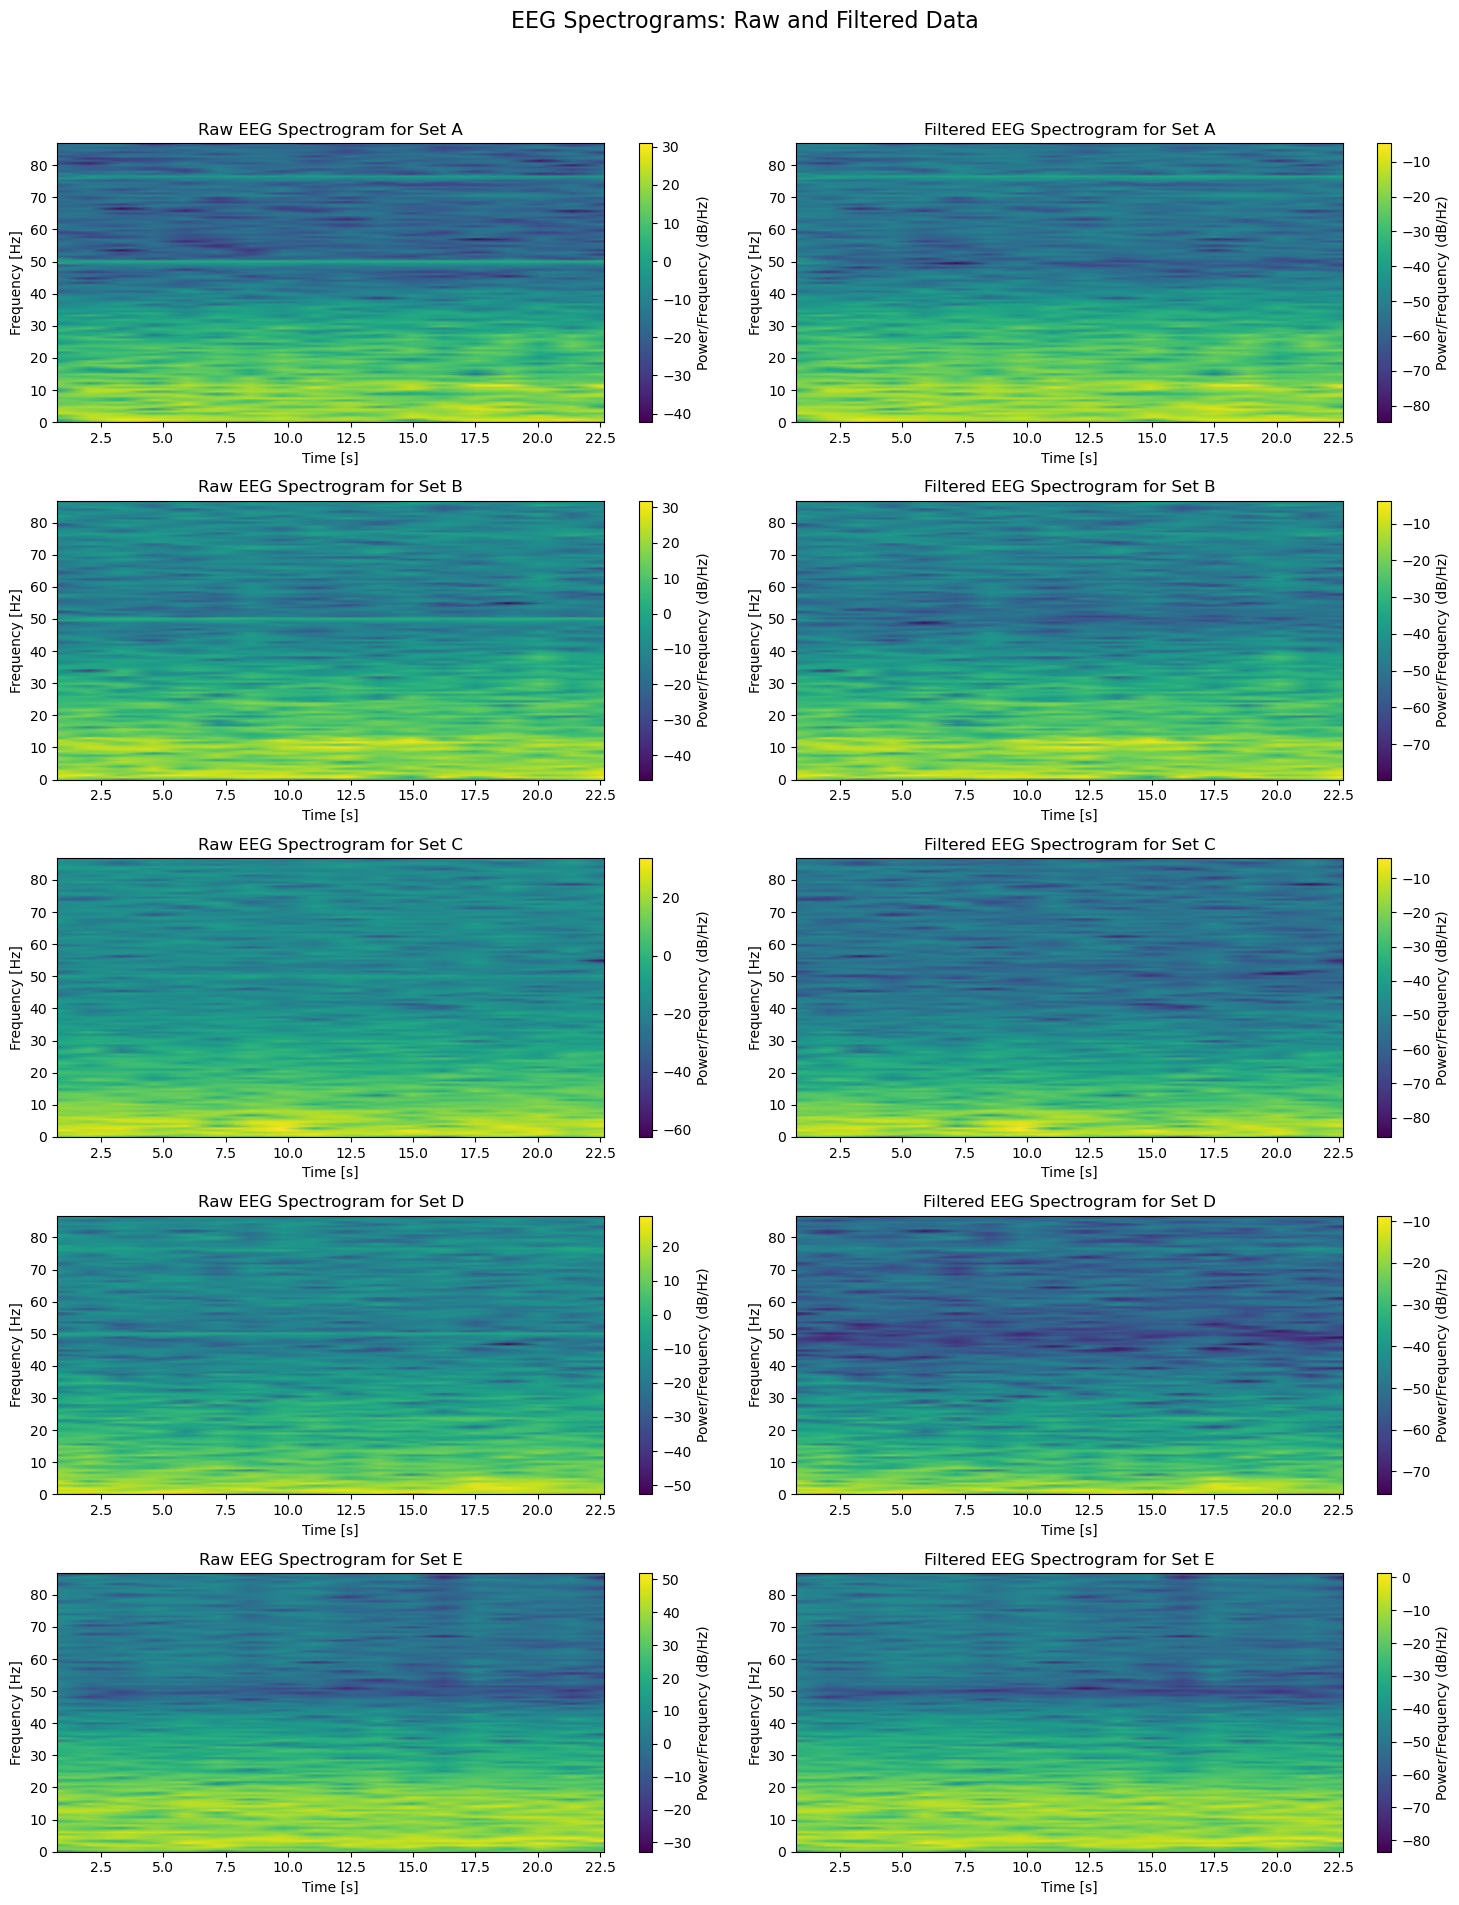

In [5]:
# Function to calculate spectrogram data (to plot multiple in a grid)
def get_spectrogram_data(data, fs=sampling_rate):
    """
    Calculate the spectrogram data for the provided EEG data.
    Parameters:
        data: 1D array of EEG data
        fs: Sampling rate of the data (default is 256 Hz)
    Returns:
        f, t, Sxx: Frequency, time, and power spectral density for the spectrogram.
    """
    f, t, Sxx = spectrogram(data, fs)
    return f, t, Sxx

# Initialize plot
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(15, 20))
fig.suptitle("EEG Spectrograms: Raw and Filtered Data", fontsize=16)

# Plot spectrograms for raw and filtered data from one file in each set
for i, set_name in enumerate(raw_data_all_sets.keys()):
    # Select the first file in each set for demonstration
    raw_data = raw_data_all_sets[set_name][0]
    filtered_data = filtered_data_all_sets[set_name][0]
    
    # Get spectrogram data for raw and filtered data
    f_raw, t_raw, Sxx_raw = get_spectrogram_data(raw_data)
    f_filt, t_filt, Sxx_filt = get_spectrogram_data(filtered_data)
    
    # Plot raw data spectrogram
    ax_raw = axes[i, 0]
    cax_raw = ax_raw.pcolormesh(t_raw, f_raw, 10 * np.log10(Sxx_raw), shading='gouraud')
    ax_raw.set_title(f"Raw EEG Spectrogram for Set {set_name}")
    ax_raw.set_ylabel('Frequency [Hz]')
    ax_raw.set_xlabel('Time [s]')
    fig.colorbar(cax_raw, ax=ax_raw, label='Power/Frequency (dB/Hz)')
    
    # Plot filtered data spectrogram
    ax_filt = axes[i, 1]
    cax_filt = ax_filt.pcolormesh(t_filt, f_filt, 10 * np.log10(Sxx_filt), shading='gouraud')
    ax_filt.set_title(f"Filtered EEG Spectrogram for Set {set_name}")
    ax_filt.set_ylabel('Frequency [Hz]')
    ax_filt.set_xlabel('Time [s]')
    fig.colorbar(cax_filt, ax=ax_filt, label='Power/Frequency (dB/Hz)')

# Adjust layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


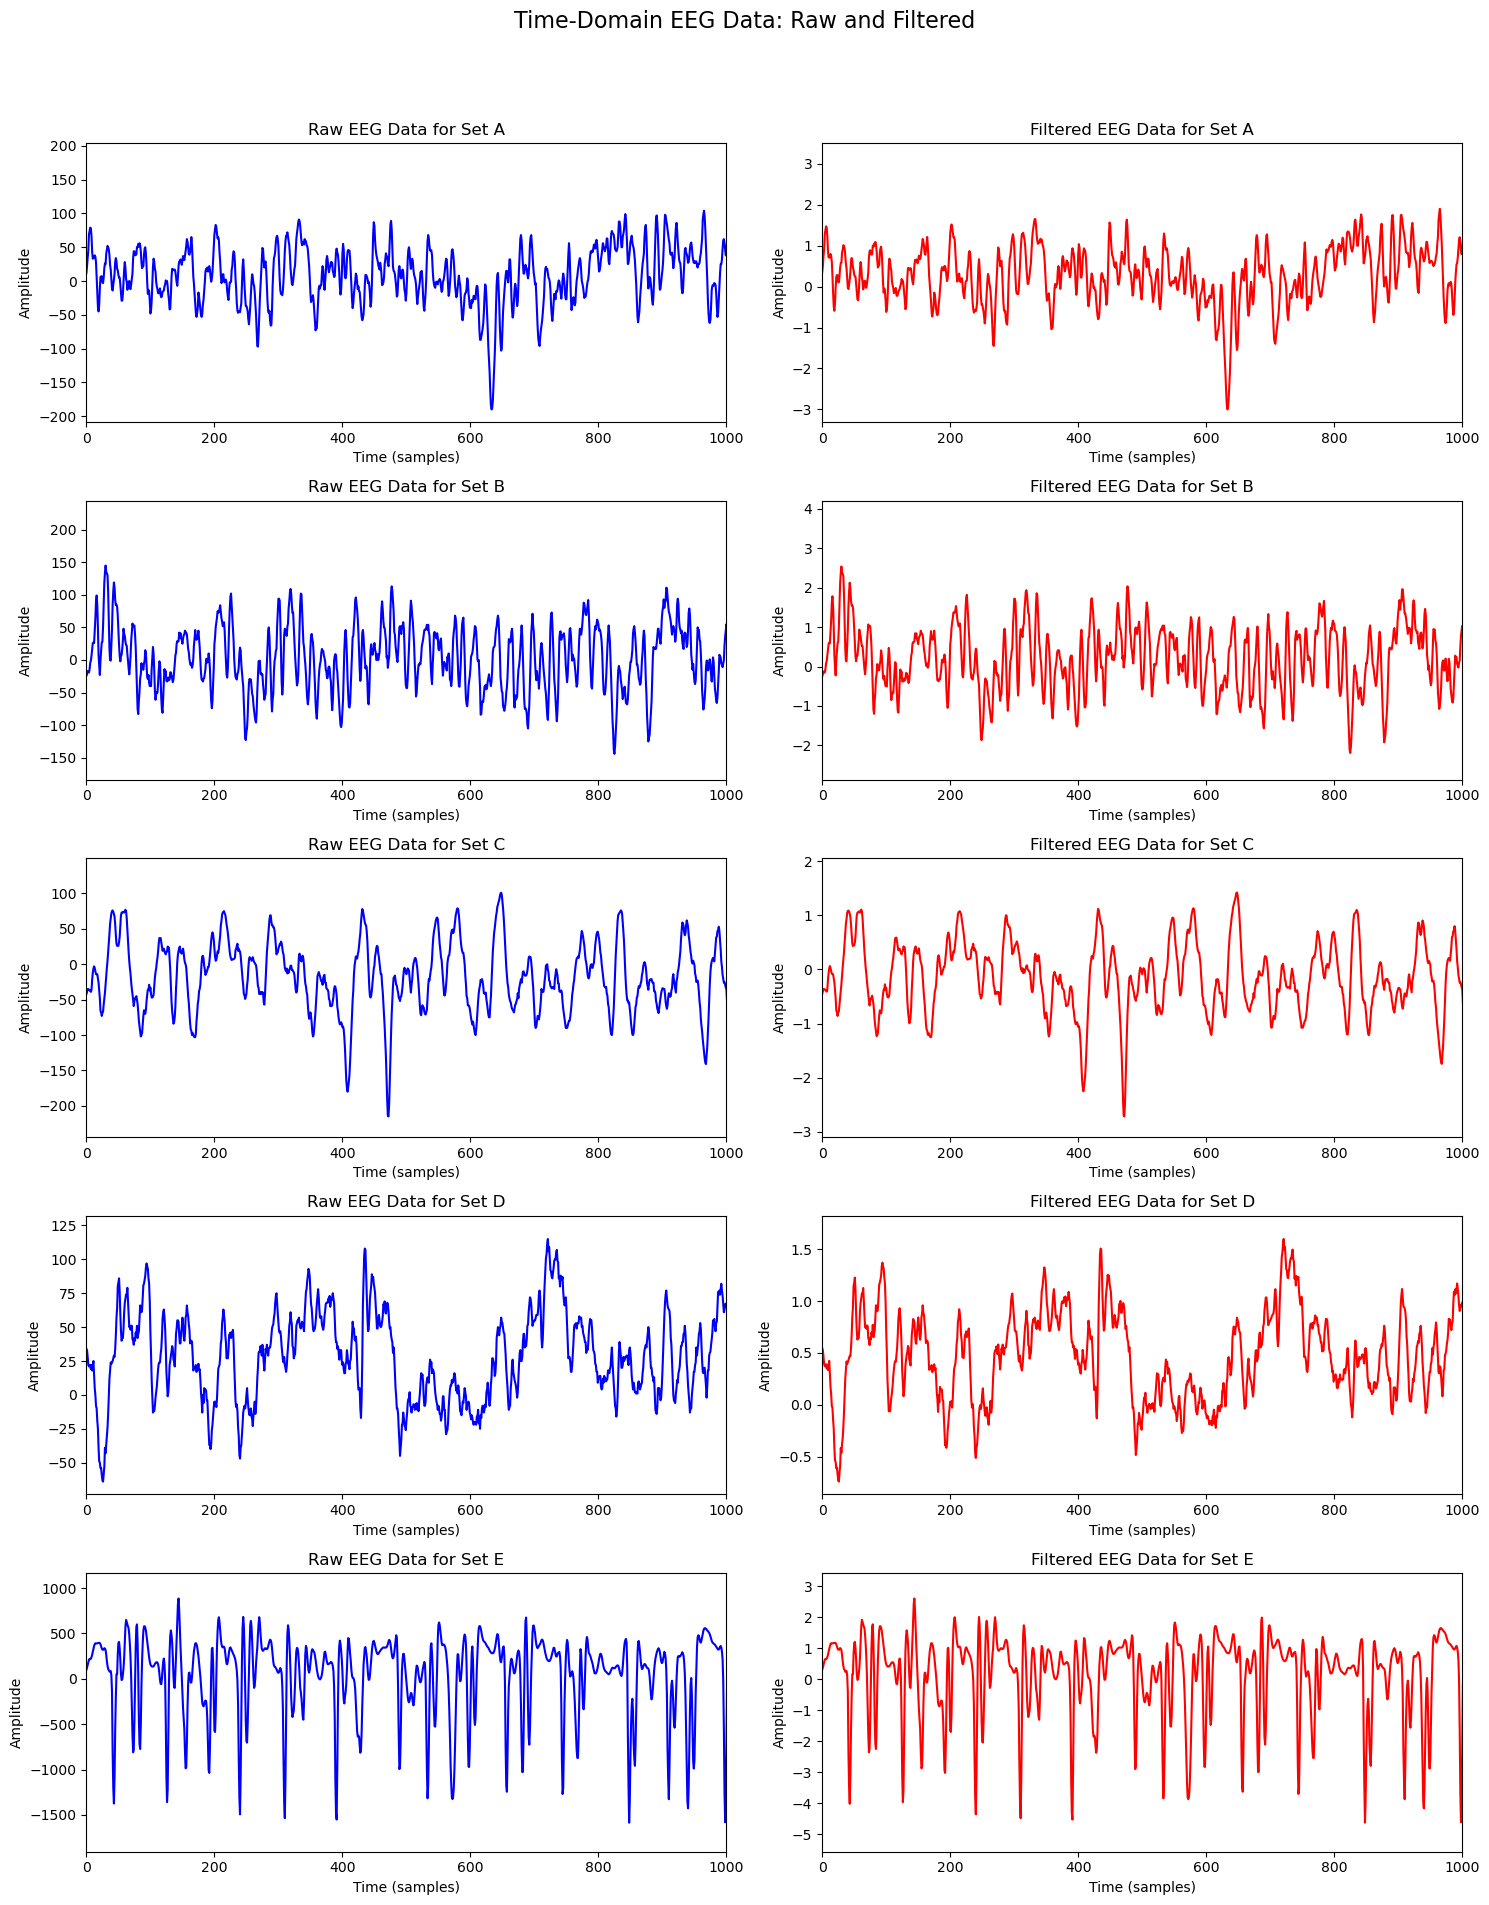

In [6]:
### Time domain visualization

# Initialize the plot
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(15, 20))
fig.suptitle("Time-Domain EEG Data: Raw and Filtered", fontsize=16)

# Plot raw and filtered data for one file in each set
for i, set_name in enumerate(raw_data_all_sets.keys()):
    # Select the first file in each set for demonstration
    raw_data = raw_data_all_sets[set_name][0]
    filtered_data = filtered_data_all_sets[set_name][0]
    
    # Plot raw data
    ax_raw = axes[i, 0]
    ax_raw.plot(raw_data, color='blue')
    ax_raw.set_title(f"Raw EEG Data for Set {set_name}")
    ax_raw.set_xlabel("Time (samples)")
    ax_raw.set_ylabel("Amplitude")
    ax_raw.set_xlim([0, 1000])  # Limit the x-axis for better visualization
    
    # Plot filtered data
    ax_filtered = axes[i, 1]
    ax_filtered.plot(filtered_data, color='red')
    ax_filtered.set_title(f"Filtered EEG Data for Set {set_name}")
    ax_filtered.set_xlabel("Time (samples)")
    ax_filtered.set_ylabel("Amplitude")
    ax_filtered.set_xlim([0, 1000])  # Limit the x-axis for better visualization

# Adjust layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()



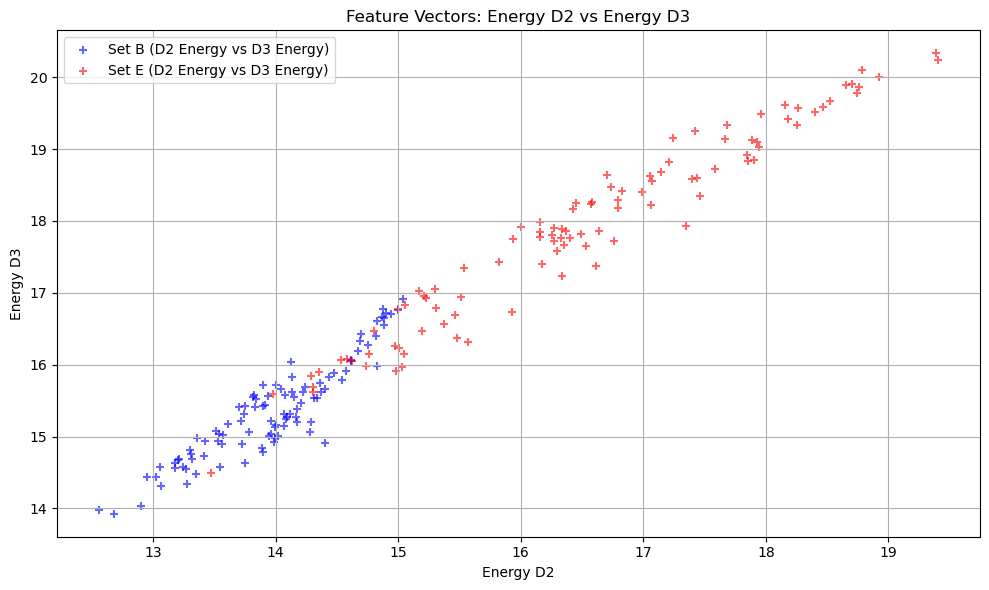

In [37]:
### Checking rondom feature 

# all_sets_data = {key: np.array(val) for key, val in filtered_data_all_sets.items()}
all_sets_data = {key: np.array(val) for key, val in raw_data_all_sets.items()}

# Function to compute energy of wavelet coefficients
def compute_energy(coefficients):
    return np.sum(np.square(coefficients))

# Wavelet to use for DWT
wavelet = 'db2'

# level of decomposition
dlevel = 6

# To store feature vectors for each set
feature_vectors_B = []
feature_vectors_E = []

# Process Set B (Blue)
for eeg_data in all_sets_data['B']:
    coeffs_B = pywt.wavedec(eeg_data, wavelet, level=dlevel)  # 3 levels of decomposition
    d2_B = coeffs_B[-2]  # D2 coefficients (second detail level)
    d3_B = coeffs_B[-3]  # D3 coefficients (third detail level)
    
    # Compute energy for D2 and D3
    d2_energy_B = compute_energy(d2_B)
    d3_energy_B = compute_energy(d3_B)
    
    # Create feature vector for Set B
    feature_vectors_B.append([d2_energy_B, d3_energy_B])

# Process Set E (Red)
for eeg_data in all_sets_data['E']:
    coeffs_E = pywt.wavedec(eeg_data, wavelet, level=dlevel)  # 3 levels of decomposition
    d2_E = coeffs_E[-2]  # D2 coefficients (second detail level)
    d3_E = coeffs_E[-3]  # D3 coefficients (third detail level)
    
    # Compute energy for D2 and D3
    d2_energy_E = compute_energy(d2_E)
    d3_energy_E = compute_energy(d3_E)
    
    # Create feature vector for Set E
    feature_vectors_E.append([d2_energy_E, d3_energy_E])

# Convert feature vectors to numpy arrays for easy plotting
feature_vectors_B = np.array(feature_vectors_B)
feature_vectors_E = np.array(feature_vectors_E)

# Plot the feature vectors
plt.figure(figsize=(10, 6))

# Plotting feature vectors for Set B
plt.scatter(np.log(feature_vectors_B[:, 0]), np.log(feature_vectors_B[:, 1]),  marker='+', color='blue', label='Set B (D2 Energy vs D3 Energy)', alpha=0.6)

# Plotting feature vectors for Set E
plt.scatter(np.log(feature_vectors_E[:, 0]), np.log(feature_vectors_E[:, 1]), marker='+', color='red', label='Set E (D2 Energy vs D3 Energy)', alpha=0.6)

# Set plot labels and title
plt.title('Feature Vectors: Energy D2 vs Energy D3')
plt.xlabel('Energy D2')
plt.ylabel('Energy D3')
plt.legend()
plt.grid()
# plt.xlim([0, 200])
# plt.ylim([0, 1000])

# Show the plot
plt.tight_layout()
plt.show()

In [51]:
all_sets_data = {key: np.array(val) for key, val in filtered_data_all_sets.items() if key in ['B', 'E']}

In [53]:
### Energy, STD, Entropy Calculations

def calculate_all_energies(coeffs):
    """
    Calculate the energy for each level of detail and approximation coefficients.
    """
    return [np.sum(np.square(c)) for c in coeffs]

def calculate_all_energies(coeffs):
    """
    Calculate the energy for each level of detail and approximation coefficients.
    """
    return [np.sum(np.square(c)) for c in coeffs]

def calculate_all_std(coeffs):
    """
    Calculate the standard deviation for each level of detail and approximation coefficients.
    """
    return [np.std(c) for c in coeffs]

def calculate_all_entropy(coeffs):
    """
    Calculate the entropy for each level of detail and approximation coefficients
    based on the formula: ENT_i = -sum(D_ij^2 * log(D_ij^2))
    """
    entropies = []
    for c in coeffs:
        squared_coeffs = np.square(c)
        entropy = -np.sum(squared_coeffs * np.log(squared_coeffs + 1e-12))  # Adding 1e-12 to avoid log(0)
        entropies.append(entropy)
    return entropies

In [68]:
### Wavelet Transform Feature Extraction
def wavelet_decomposition(signal, wavelet, level):
    """
    Perform wavelet decomposition up to the specified level using the provided wavelet function.
    """
    coeffs = pywt.wavedec(signal, wavelet, level=level)
    return coeffs

Feature vector length:  2
Decomposition Level 1 - Mean Accuracy: 0.6500
Feature vector length:  3
Decomposition Level 2 - Mean Accuracy: 0.6800
Feature vector length:  4
Decomposition Level 3 - Mean Accuracy: 0.7800
Feature vector length:  5
Decomposition Level 4 - Mean Accuracy: 0.8700
Feature vector length:  6
Decomposition Level 5 - Mean Accuracy: 0.9700
Feature vector length:  7
Decomposition Level 6 - Mean Accuracy: 0.9800
Feature vector length:  8
Decomposition Level 7 - Mean Accuracy: 0.9550
Feature vector length:  9
Decomposition Level 8 - Mean Accuracy: 0.9600


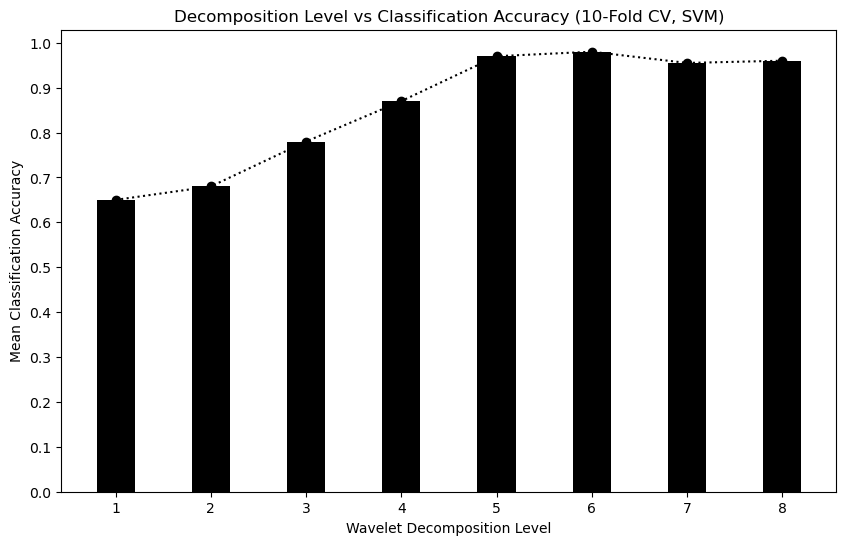

In [83]:
# Prepare data function with different feature types
def prepare_data(all_signals, feature_type='energy', wavelet='coif1', level=6):
    features = []
    labels = []
    
    for set_name, signals in all_signals.items():
        label = 1 if set_name == 'E' else 0  # Assuming 'E' is epileptic, others are normal
        for signal in signals:
            coeffs = wavelet_decomposition(signal, wavelet, level=level)
            if feature_type == 'energy':
                energies = calculate_all_energies(coeffs)
                features.append(energies) 
            elif feature_type == 'std':
                stds = calculate_all_std(coeffs)
                features.append(stds)
            elif feature_type == 'entropy':
                entropies = calculate_all_entropy(coeffs)
                features.append(entropies)
            elif feature_type == 'energy_std':
                energies = calculate_all_energies(coeffs)
                stds = calculate_all_std(coeffs)
                features.append(np.concatenate([energies, stds]))
            else:
                raise ValueError("Invalid feature type. Use 'energy', 'std', 'entropy', or 'energy_std'.")
           
            labels.append(label)

    #validation feature vector length
    print("Feature vector length: ", len(features[0]))
    
    # Convert lists to numpy arrays for cross-validation compatibility
    return np.array(features), np.array(labels)


# Function to evaluate decomposition levels with 10-fold cross-validation
def evaluate_decomposition_levels_with_svm_cv(all_signals, feature_type='energy', wavelet='coif1', max_level=10, n_splits=1):
    results = []
    
    # Iterate over different decomposition levels (1 to max_level)
    for level in range(1, max_level + 1):
        X, y = prepare_data(all_signals, feature_type=feature_type, wavelet=wavelet, level=level)
        
        # Initialize 10-fold cross-validation
        skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
        accuracies = []
        
        # Perform cross-validation
        for train_index, test_index in skf.split(X, y):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
            
            # Train SVM and calculate accuracy
            svm = SVC(C=10, gamma='scale', kernel='rbf')
            svm.fit(X_train, y_train)
            accuracy = svm.score(X_test, y_test)
            accuracies.append(accuracy)
        
        # Average accuracy for current level across all folds
        mean_accuracy = np.mean(accuracies)
        results.append((level, mean_accuracy))
        print(f"Decomposition Level {level} - Mean Accuracy: {mean_accuracy:.4f}")
    
    return results

# Plot function for results
def plot_bar_results_with_line(results, max_level=10):
    levels = [r[0] for r in results]
    accuracies = [r[1] for r in results]
    
    plt.figure(figsize=(10, 6))
    
    # Create a bar plot with thinner bars
    plt.bar(levels, accuracies, color='black', width=0.4)
    
    # Draw a line through the tops of the bars
    plt.plot(levels, accuracies, marker='o', linestyle=':', color='black', linewidth=1.5)
    
    # Set x-axis and y-axis ticks
    plt.xticks(np.arange(1, max_level + 1, 1))  # X-axis ticks from 1 to max_level
    plt.yticks(np.arange(0, 1.1, 0.1))  # Y-axis ticks from 0 to 1 in increments of 0.1
    
    # Adding labels and title
    plt.title('Decomposition Level vs Classification Accuracy (10-Fold CV, SVM)')
    plt.xlabel('Wavelet Decomposition Level')
    plt.ylabel('Mean Classification Accuracy')
    
    plt.show()

# Example usage with 10-fold cross-validation
results_cv = evaluate_decomposition_levels_with_svm_cv(all_sets_data, feature_type='energy', wavelet='coif1', max_level=8, n_splits=10)
plot_bar_results_with_line(results_cv, max_level=8)


Feature vector length:  2
Decomposition Level 1 - Mean Accuracy: 0.6500
Feature vector length:  3
Decomposition Level 2 - Mean Accuracy: 0.7000
Feature vector length:  4
Decomposition Level 3 - Mean Accuracy: 0.8150
Feature vector length:  5
Decomposition Level 4 - Mean Accuracy: 0.8750
Feature vector length:  6
Decomposition Level 5 - Mean Accuracy: 0.9600
Feature vector length:  7
Decomposition Level 6 - Mean Accuracy: 0.9500
Feature vector length:  8
Decomposition Level 7 - Mean Accuracy: 0.9350
Feature vector length:  9
Decomposition Level 8 - Mean Accuracy: 0.9400


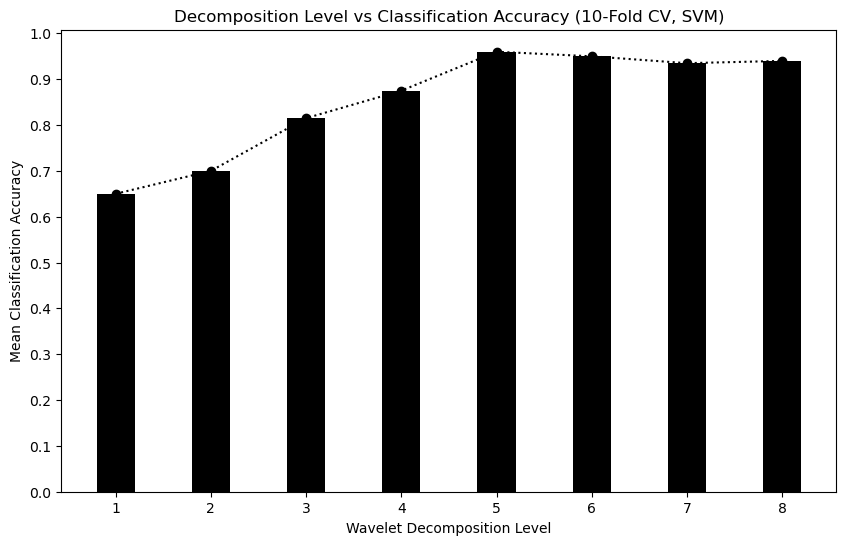

In [81]:
results = evaluate_decomposition_levels_with_svm_cv(all_sets_data, feature_type='energy',wavelet='db4',max_level=8,n_splits=10)
plot_bar_results_with_line(results,max_level=8)

In [ ]:
### QMF-based Wavelet Decomposition Experiments

def get_qmf_filters(wavelet_name):
    """
    Retrieve the low-pass and high-pass filter coefficients for a given wavelet.
    """
    wavelet = pywt.Wavelet(wavelet_name)
    low_pass_filter = wavelet.dec_lo  # Low-pass filter coefficients
    high_pass_filter = wavelet.dec_hi  # High-pass filter coefficients
    return np.array(low_pass_filter), np.array(high_pass_filter)

def apply_filter(signal, filter_coeffs):
    """
    Convolves the signal with the filter coefficients and downsamples the result by 2.
    """
    filtered_signal = np.convolve(signal, filter_coeffs, mode='full')
    downsampled_signal = filtered_signal[::2]  # Downsample by taking every other sample
    return downsampled_signal

def qmf_wavelet_decomposition(signal, levels, wavelet_name='coif1'):
    """
    Perform wavelet decomposition using Quadrature Mirror Filters (QMF) for specified wavelet.
    
    Parameters:
    - signal: The input signal to decompose.
    - levels: Number of decomposition levels.
    - wavelet_name: Name of the wavelet ('coif1' or 'db2').
    
    Returns:
    - A list containing detail and approximation coefficients for each level.
    """
    # Get QMF filters for the specified wavelet
    low_pass_filter, high_pass_filter = get_qmf_filters(wavelet_name)
    coeffs = []
    approx = signal

    for level in range(levels):
        # Apply low-pass and high-pass filters
        approx_next = apply_filter(approx, low_pass_filter)  # Approximation
        detail = apply_filter(approx, high_pass_filter)  # Detail

        # Store the detail coefficients for the current level
        coeffs.append((detail, approx_next))
        
        # Update the approximation for the next level
        approx = approx_next

    return coeffs

# Example usage
# Generate a test signal (e.g., sine wave with noise)
np.random.seed(0)
signal = np.sin(np.linspace(0, 4 * np.pi, 4096*4)) + 0.1 * np.random.randn(4096*4)

# Perform QMF-based wavelet decomposition for coif1
levels = 10
coeffs_coif1 = qmf_wavelet_decomposition(signal, levels, wavelet_name='coif1')

# Perform QMF-based wavelet decomposition for db2
coeffs_db2 = qmf_wavelet_decomposition(signal, levels, wavelet_name='db2')

# Plot the original signal and decomposed components for coif1
plt.figure(figsize=(24, 16))
plt.subplot(levels + 1, 1, 1)
plt.plot(signal, color='black')
plt.title("Original Signal")

for i, (detail, approx) in enumerate(coeffs_coif1, 1):
    plt.subplot(levels + 1, 1, i + 1)
    plt.plot(detail, color='blue', label=f'Detail (Level {i}) - coif1')
    plt.plot(approx, color='red', label=f'Approximation (Level {i}) - coif1')
    plt.legend()

plt.tight_layout()
plt.show()

# Plot the original signal and decomposed components for db2
plt.figure(figsize=(24, 16))
plt.subplot(levels + 1, 1, 1)
plt.plot(signal, color='black')
plt.title("Original Signal")

for i, (detail, approx) in enumerate(coeffs_db2, 1):
    plt.subplot(levels + 1, 1, i + 1)
    plt.plot(detail, color='blue', label=f'Detail (Level {i}) - db2')
    plt.plot(approx, color='red', label=f'Approximation (Level {i}) - db2')
    plt.legend()

plt.tight_layout()
plt.show()
